# Paired guide similarity analysis

In [4]:
import scanpy as sc
import pandas as pd
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import scipy.stats as stats
import sklearn.linear_model as lm
import sklearn.metrics as metrics
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
data_path = '/mnt/c/Users/minch/Data/bmdc/'

### Define the models to be studied

For each model, specify the path to the regression outputs

In [6]:
models = {
    'Base':'analysis/beta_null.csv',
    
    'PCA_5':'analysis/beta_0_5.csv',
    'PCA_10':'analysis/beta_0_10.csv',
    'PCA_20':'analysis/beta_0_20.csv',
    
    'VAE_64_5':'analysis/beta_64_5.csv',
    'VAE_128_5':'analysis/beta_128_5.csv',
    'VAE_256_5':'analysis/beta_256_5.csv',
    
    'VAE_64_10':'analysis/beta_64_10.csv',
    'VAE_128_10':'analysis/beta_128_10.csv',
    'VAE_256_10':'analysis/beta_256_10.csv',
    
    'VAE_64_20':'analysis/beta_64_20.csv',
    'VAE_128_20':'analysis/beta_128_20.csv',
    'VAE_256_20':'analysis/beta_256_20.csv',
}

### Paired guides

In [7]:
detailed_results = []
results = []
for name, path in models.items():
    
    coefs_df = pd.read_csv(data_path + path, index_col=0)
    guide_list = coefs_df.columns.tolist()
    
    # Get a list of guides that have an effect
    sig_guide_list = coefs_df.columns[coefs_df.max(axis=0) > 0.15]
    sig_guide_genes = [x.split('_')[1] for x in sig_guide_list]
    
    # Generate combinations of guides
    guide_pairs = pd.DataFrame(itertools.combinations(guide_list, 2),columns=['guide1', 'guide2'])
    guide_pairs['target_gene_1'] = guide_pairs['guide1'].str.split('_').str[1]
    guide_pairs['target_gene_2'] = guide_pairs['guide2'].str.split('_').str[1]
    guide_pairs['paired'] = guide_pairs['target_gene_1'] == guide_pairs['target_gene_2']
    guide_pairs['sig'] = guide_pairs['target_gene_1'].isin(sig_guide_genes) & guide_pairs['target_gene_2'].isin(sig_guide_genes)
    
    # A pair is a positive control if it's targeting same gene and it has an effect
    guide_pairs['pos_ctrl'] = guide_pairs['paired'] & guide_pairs['sig']
    
    # Compute correlations
    guide_pairs['beta_corr'] = [stats.spearmanr(coefs_df[row['guide1']], coefs_df[row['guide2']])[0] for idx, row in guide_pairs.iterrows()]
    guide_pairs['method'] = name
    
    detailed_results.append(guide_pairs)
    ks_stat, ks_pval = stats.ks_2samp( 
        guide_pairs.query('~pos_ctrl').beta_corr,
        guide_pairs.query('pos_ctrl').beta_corr)
    results.append((name, ks_stat, ks_pval))
    
detailed_results = pd.concat(detailed_results)
results = pd.DataFrame(results, columns=['method', 'ks_stat', 'ks_pval'])

In [8]:
detailed_results.groupby(['method', 'pos_ctrl'])

<Axes: xlabel='method', ylabel='beta_corr'>

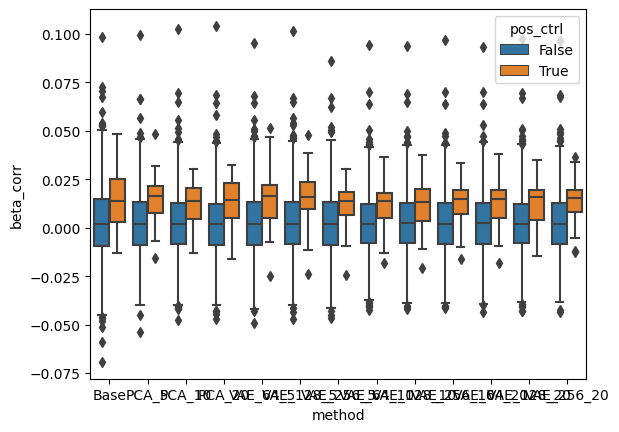

In [9]:
sns.boxplot(x='method', y='beta_corr', hue='pos_ctrl', data=detailed_results)

In [18]:
detailed_results.query('method == "Base"').beta_corr

0      -0.002774
1       0.017001
2      -0.009540
3      -0.024597
4      -0.018068
          ...   
1591    0.002757
1592    0.029844
1593   -0.017518
1594   -0.013794
1595    0.006299
Name: beta_corr, Length: 1596, dtype: float64

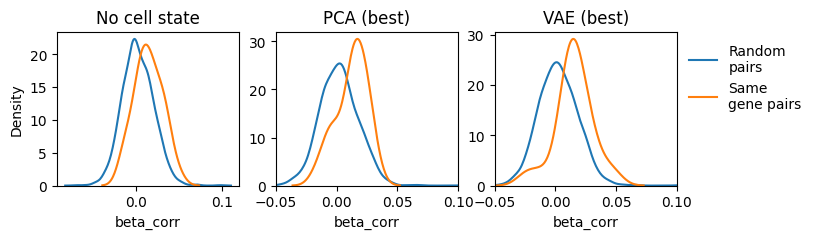

In [41]:
plt.figure(figsize=(8, 2))
plt.subplot(1, 3, 1)

sns.kdeplot(detailed_results.query('method == "Base" & ~pos_ctrl').beta_corr)
sns.kdeplot(detailed_results.query('method == "Base" & pos_ctrl').beta_corr)
plt.title('No cell state')

plt.subplot(1, 3, 2)
sns.kdeplot(detailed_results.query('method == "PCA_20" & ~pos_ctrl').beta_corr)
sns.kdeplot(detailed_results.query('method == "PCA_20" & pos_ctrl').beta_corr)
plt.xlim(-0.05, 0.1)
plt.ylabel('')
plt.title('PCA (best)')

plt.subplot(1, 3, 3)
sns.kdeplot(detailed_results.query('method == "VAE_128_5" & ~pos_ctrl').beta_corr)
sns.kdeplot(detailed_results.query('method == "VAE_128_5" & pos_ctrl').beta_corr)
plt.xlim(-0.05, 0.1)
plt.ylabel('')
plt.title('VAE (best)')
plt.legend(['Random\npairs', 'Same\ngene pairs'], frameon=False, bbox_to_anchor=(1, 1))

plt.savefig('beta_correlation_densities.pdf', bbox_inches='tight')

In [42]:
results

,method,ks_stat,ks_pval
0,Base,0.359414,0.002365
1,PCA_5,0.414895,0.000239
2,PCA_10,0.330357,0.010491
3,PCA_20,0.432252,0.000158
4,VAE_64_5,0.341158,0.004643
5,VAE_128_5,0.488506,0.000027
6,VAE_256_5,0.395038,0.000780
7,VAE_64_10,0.355916,0.003494
8,VAE_128_10,0.355280,0.003575
9,VAE_256_10,0.399491,0.000650


In [43]:
results['logp'] = -np.log10(results['ks_pval'])

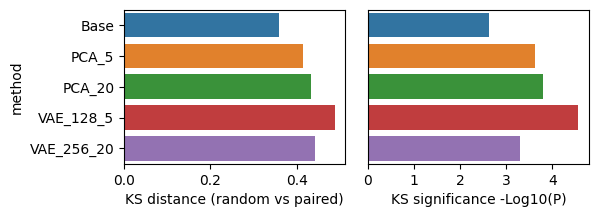

In [69]:
plt.figure(figsize=(6, 2))
plt.subplots_adjust(wspace=0.1)
plt.subplot(1, 2, 1)
sns.barplot(y='method', x='ks_stat', data=results.query('method =="Base" | ks_stat > 0.4'))
plt.xlabel('KS distance (random vs paired)')
plt.subplot(1, 2, 2)
sns.barplot(y='method', x='logp', data=results.query('method =="Base" | ks_stat > 0.4'))
plt.xlabel('KS significance -Log10(P)')
plt.yticks([]); plt.ylabel('')

plt.savefig('ks_statistics.pdf', bbox_inches='tight')

In [71]:
results.index = results['method']
results.drop('method', inplace=True, axis=1)

In [75]:
results.to_csv('full_table.csv')